In [84]:
import import_ipynb
import numpy as np
from rtree import index
import math
import time
import copy
import sys
from collections import defaultdict

In [131]:
class MyHist:
    '''
    My histogram class, for ease of maintenance
    '''
    
    def __init__(self, dataset, buckets, domains, is_query_hist, hist_type, dim_probs=[], query_threshold_up = 2, query_threshold_low = 2):
        ''' Create numpy format histogram for queryset or dataset.
        @param dataset        numpy format, could be dataset (point) or queryset (hyper rectangles) depends on is_query_hist
        @param buckets[..]    the number of buckets in each dimension
        @param hist_type      the type of hist, 0: normal (1*d-dimensional histgramdd) 1: independent (d*1-dimensional histogram)
        @param dim_probs[..]  the probability of queries in each dimension
        '''
        self.buckets = buckets
        self.domains = [tuple(domains[i]) for i in range(len(domains))]
        self.dims = len(buckets)
        self.is_query_hist = is_query_hist
        self.hist_type = hist_type
        self.query_threshold_up = query_threshold_up
        self.query_threshold_low = query_threshold_low 
        
        self.dim_steps = [(domains[k][1] - domains[k][0]) / buckets[k] for k in range(self.dims)]
        self.records_amount = len(dataset)
        self.dim_probs = dim_probs
        self.query_threshold_up_each_dims = []
        self.query_threshold_low_each_dims = []
        if len(dim_probs) != 0:
            for k in range(self.dims):
                self.query_threshold_up_each_dims.append(self.records_amount * (1-dim_probs[k]) + query_threshold_up)
                self.query_threshold_low_each_dims.append(self.records_amount * (1-dim_probs[k]) + query_threshold_low)
        
        if is_query_hist == False:
            if hist_type == 0:
                self.hist, edges = np.histogramdd(dataset, bins = tuple(buckets), range = self.domains)
            elif hist_type == 1:
                self.hist = []
                for d in range(self.dims):
                    self.hist.append(np.histogram(dataset[:,d], bins = buckets[d], range = self.domains[d]))
        else:
            queryset = dataset # dataset is actually queryset
            if hist_type == 0:
                self.hist = np.full(tuple(buckets), 0) # used to store count, cannot use full for set() or it will be 'reference'
                self.qid_hist = np.ndarray(tuple(buckets),dtype=object) # an extra hist to store qid will be created
                for index, value in np.ndenumerate(self.qid_hist):
                    self.qid_hist[index] = set()
                     
            elif hist_type == 1:
                self.hist = []
                self.qid_hist = []
                for d in range(self.dims):
                    self.hist.append(np.array([0]*buckets[d]))
                    self.qid_hist.append(np.array([set() for i in range(buckets[d])])) # this is different, note [set()] * n is reference!
                
            # insert query into thses histograms
            for i in range(len(queryset)):
                self.InserQueryIntoHist(i, queryset[i])
            
    
    def create_accu_hist(self, hist=None):
        ''' Create accumulative histogram (for dataset).
        @param hist    if this argument is given, apply accu on this histogram, should be numpy format
        '''
        if self.hist_type == 1:
            print("Fatal Error: ","cannot apply accu hist on independent histogram!", file=sys.stderr)
            return None
        
        if hist != None:
            self.accu_hist = copy.deepcopy(hist)
        else:
            self.accu_hist = copy.deepcopy(self.hist)
            
        for k in reversed(range(len(self.accu_hist.shape))): # for each dimension
            for i in range(1,self.accu_hist.shape[k]):
                # https://stackoverflow.com/questions/42817508/get-the-i-th-slice-of-the-k-th-dimension-in-a-numpy-array
                self.accu_hist[(slice(None),) * k + (i,)] += self.accu_hist[(slice(None),) * k + (i-1,)] 
                    
        return self.accu_hist
    
    
    def query_accu_hist(self, query):
        ''' Query accu histogram.
        @param query    
        @param domain    
        '''
        if self.hist_type == 1:
            print("Fatal Error: ","cannot apply accu query on independent histogram!", file=sys.stderr)
            return None

        # notice there should be -1 here for min
        query_index_min = [int((query[k][0] - self.domains[k][0]) / self.dim_steps[k])-1 for k in range(self.dims)] 
        query_index_max = [int((query[k][1] - self.domains[k][0]) / self.dim_steps[k]) for k in range(self.dims)]
        query_index_min = [min(query_index_min[k], self.accu_hist.shape[k]-1) for k in range(self.dims)]
        query_index_max = [min(query_index_max[k], self.accu_hist.shape[k]-1) for k in range(self.dims)]
        
        approximate_result = 0
        for value in range(0, 2**self.dims):

            ignore_flag = False # to skip those 0 accumulation point

            # used to denotes the upper and lower end
            query_expr = bin(value).split('b')[1]
            query_expr = '0'*(self.dims - len(query_expr)) + query_expr # add 0s at the front to make the dimensions consistent
            low_count = query_expr.count('0')

            # find the corresponding sign
            sign = 1
            if low_count % 2 != 0:
                sign = -1

            # find corresponding index of the prefix sum array
            indexes = ()
            for k in range(self.dims):
                if query_expr[self.dims-k-1] == '0':
                    if query_index_min[k] < 0:
                        ignore_flag = True
                        break # this accumulation is 0
                    indexes += (slice(query_index_min[k], query_index_min[k]+1, 1),) # the 1 here is stride
                else:
                    indexes += (slice(query_index_max[k], query_index_max[k]+1, 1),)

            # calculate the result for this one
            if not ignore_flag:
                approximate_result += sign * self.accu_hist[indexes]

        return float(approximate_result)
    
    
    def InserQueryIntoHist(self, qid, query, return_new_region = False):
        ''' Insert a single query to histogram. The histogram could be type 0 or type 1, used to maintain the count.
        @param qid          the query id, should be unique
        @param query        the query itself
        @param threshold    the threshold for query to be regarded as distributive queries
        '''
        if self.is_query_hist == False:
            print("Fatal Error: ","cannot apply query insert on non-queryset histogram!", file=sys.stderr)
            return None
        
        query_index_min = [int((query[k][0] - self.domains[k][0]) / self.dim_steps[k]) for k in range(self.dims)]
        # because we use range selection in the following, we need to add 1 to include the original index
        query_index_max = [int((query[k][1] - self.domains[k][0]) / self.dim_steps[k]) + 1 for k in range(self.dims)]
        query_index_min = [min(query_index_min[k], self.buckets[k]-1) for k in range(self.dims) ]
        # note that because we only use the max side for range, we could allow it gregater
        query_index_max = [min(query_index_max[k], self.buckets[k]) for k in range(self.dims) ]
        
        # https://stackoverflow.com/questions/35215161/most-efficient-way-to-map-function-over-numpy-array
        set_add = lambda t: t.add(qid)
        vfunc = np.vectorize(set_add) 
        
        new_distribution_regions = None
        
        if self.hist_type == 0:
            
            # find the overlap indexes
            indexes = ()
            for k in range(len(query_index_min)):
                indexes += (slice(query_index_min[k], query_index_max[k], 1),) # the 1 here is stride
            
            self.hist[indexes] += 1 # the query hist for count 
            vfunc(self.qid_hist[indexes]) # add the qid in query hist for qids
  
            if return_new_region:
                # whether a region just become distribution query region
                new_distribution_regions = np.argwhere(self.hist == self.query_threshold_up)
                new_distribution_regions = [tuple(new_distribution_regions[i]) for i in range(len(new_distribution_regions))]
            return new_distribution_regions 
        
        elif self.hist_type == 1:
            
            for k in range(self.dims):
                #print(k, query_index_min[k], query_index_max[k])
                if query_index_max[k] == query_index_min[k]:
                    query_index_max[k] += 1
                self.hist[k][query_index_min[k]:query_index_max[k]] += 1
                vfunc(self.qid_hist[k][(slice(query_index_min[k], query_index_max[k], 1),)])
            
            if return_new_region:
                new_distribution_regions = [np.argwhere(self.hist[k] == self.query_threshold_up) for k in range(self.dims)]
                new_distribution_regions = [[tuple(new_distribution_regions[k][i]) for i in range(len(new_distribution_regions[k]))] \
                                            for k in range(self.dims)]
            return new_distribution_regions 
        
    def RemoveQueryFromHist(self, qid, query, return_new_region = False):
        pass
        
    def filter_distribution_query(self):
        '''
        @return distribution query ids (note only ids are returned)
        '''
        if self.is_query_hist == False:
            print("Fatal Error: ","cannot apply query classification on non-queryset histogram!", file=sys.stderr)
            return None
        
        if self.hist_type == 0:
            qid_greater_threshold = defaultdict(int) # [qid] -> Count (appear in bins greater than threshold) dict in this dimension
            qid_all = defaultdict(int) # [qid] -> Count (appear in bins) dictionary in this dimension
            to_check_regions = np.argwhere(self.hist > 0)
            
            for suffix in to_check_regions:
                suffix = tuple(suffix)
                qids = self.qid_hist[suffix]
                if self.hist[suffix] >= self.query_threshold_up:
                    for qid in qids:
                        qid_greater_threshold[qid] += 1
                        qid_all[qid] += 1
                else:
                    for qid in qids:
                        qid_all[qid] += 1
            
            filtered_qids = []
            for qid in qid_greater_threshold:
                if qid_greater_threshold[qid] / qid_all[qid] >= 0.5**(1.0/float(self.dims)):
                    filtered_qids.append(qid)
            return filtered_qids
        
        elif self.hist_type == 1:
            # first filter distribution query in each seperate dimension
            distributive_query_qids_each_dims = [set() for k in range(self.dims)]
            for k in range(self.dims):
                qid_greater_threshold = defaultdict(int) # [qid] -> Count (appear in bins greater than threshold) dict in this dimension
                qid_all = defaultdict(int) # [qid] -> Count (appear in bins) dictionary in this dimension
                for i in range(self.buckets[k]):
                    qids = self.qid_hist[k][i]
                    #if len(qids) >= self.query_threshold_up: 
                    if len(qids) >= self.query_threshold_up_each_dims[k]:
                        for qid in qids:
                            qid_greater_threshold[qid] += 1
                            qid_all[qid] += 1
                    elif len(qids) > 0:
                        for qid in qids:
                            qid_all[qid] += 1
                            
                for qid in qid_greater_threshold:
                    if qid_greater_threshold[qid] / qid_all[qid] >= 0.5**(1.0/float(self.dims)):
                        distributive_query_qids_each_dims[k].add(qid)
            
            filtered_qids = set.intersection(*distributive_query_qids_each_dims) # expand the arguments with *
            return list(filtered_qids)

In [121]:
# # - - - Test Case 1 - - -
# # Target: basic functionality
# # Result: Pass
# dataset = [[0,0],[0,2],[2,0],[2,0],[2,2],[2,2],[2,2]]
# queryset = [[[0,1],[0,1]]]
# buckets = [2, 2]
# domains = [[0, 2], [0, 2]]
# is_query_hist = True 
# hist_type = 1
# query_hist = MyHist(queryset, buckets, domains, is_query_hist, hist_type)
# print(query_hist.hist) # should be [array([1, 0]), array([1, 0])]
# print(query_hist.qid_hist) # [array([{0}, set()], dtype=object), array([{0}, set()], dtype=object)]

# # - - - Test Case 2 - - -
# # Target: perform identical to existing methods when hist_type = 0
# # Result: Pass
# # ... generate queryset here
# queryset = training_set
# buckets = [300, 300, 300]
# is_query_hist = True 
# hist_type = 0
# query_hist = MyHist(queryset, buckets, domains, is_query_hist, hist_type)
# disqids = query_hist.filter_distribution_query()
# disqids.sort()
# print(disqids) # should contains the distribution queries in training set

# # - - - Test Case 3 - - -
# # Target: 4 dimensional distribution query classification using hist_type 1
# # Result: 
# # ... generate queryset here
# queryset = training_set
# buckets = [300, 300, 300, 300]
# is_query_hist = True 
# hist_type = 1
# query_hist = MyHist(queryset, buckets, domains, is_query_hist, hist_type)
# disqids = query_hist.filter_distribution_query()
# disqids.sort()
# print(disqids) # should contains the distribution queries in training set

In [230]:
class PartitionAlgorithm:
    '''
    all methods in this class are static and perform recursive calls to themselves
    '''
    @staticmethod
    def skip_gain_for_split(original_node, child_node1, child_node2, queryset, idx):
        # original node
        lower0 = [domain[0] for domain in original_node[0]]
        upper0 = [domain[1] for domain in original_node[0]]
#         for i in range(len(lower0)):
#             if lower0[i] > upper0[i]:
#                 print("found illegal! lower: ", lower0," upper: ",upper0)
        border0 = tuple(lower0 + upper0)
        overlapped_query_id0 = list(idx.intersection(border0))
        original_overlap = original_node[1] * len(overlapped_query_id0)

        # child node 1
        lower1 = [domain[0] for domain in child_node1[0]]
        upper1 = [domain[1] for domain in child_node1[0]]
        border1 = tuple(lower1 + upper1)
        overlapped_query_id1 = list(idx.intersection(border1))
        child_node1_overlap = child_node1[1] * len(overlapped_query_id1)

        # child node 2
        lower2 = [domain[0] for domain in child_node2[0]]
        upper2 = [domain[1] for domain in child_node2[0]]
        border2 = tuple(lower2 + upper2)
        overlapped_query_id2 = list(idx.intersection(border2))
        child_node2_overlap = child_node2[1] * len(overlapped_query_id2)

        skip_gain = original_overlap - child_node1_overlap - child_node2_overlap
        return skip_gain

    @staticmethod
    def perform_split(i, kdnodes, max_skip_dim, max_skip_value, temp_dataset, dataset_dict, kdnode_dict, accu_count):
        sub_domains1 = np.copy(kdnodes[i][0])
        if kdnodes[i][0][max_skip_dim][0] < kdnodes[i][0][max_skip_dim][1]:
            sub_domains1[max_skip_dim][1] = max_skip_value - min(0.000001, 0.01 * (kdnodes[i][0][max_skip_dim][1] - \
                                                                                   kdnodes[i][0][max_skip_dim][0]))
        else:
            sub_domains1[max_skip_dim][1] = max_skip_value
        sub_domains2 = np.copy(kdnodes[i][0])
        #sub_domains2[max_skip_dim][0] = max_skip_value + 0.00001
        sub_domains2[max_skip_dim][0] = max_skip_value

        sub_dataset1 = temp_dataset[temp_dataset[:,max_skip_dim] < max_skip_value]
        sub_dataset2 = temp_dataset[temp_dataset[:,max_skip_dim] >= max_skip_value]
        sub_dataset1_size = len(sub_dataset1)
        sub_dataset2_size = len(sub_dataset2)

        parent_node_id = kdnodes[i][-4]
        sub_kdnodes_1 = [sub_domains1, sub_dataset1_size, accu_count + 1, parent_node_id, -1, -1]
        sub_kdnodes_2 = [sub_domains2, sub_dataset2_size, accu_count + 2, parent_node_id, -1, -1]

        kdnode_dict[parent_node_id][-2] = accu_count + 1
        kdnode_dict[parent_node_id][-1] = accu_count + 2
        #kdnode_dict.update({accu_count + 1: copy.deepcopy(sub_kdnodes_1)}) 
        #kdnode_dict.update({accu_count + 2: copy.deepcopy(sub_kdnodes_2)}) 
        kdnode_dict.update({accu_count + 1: sub_kdnodes_1}) 
        kdnode_dict.update({accu_count + 2: sub_kdnodes_2}) 

        kdnodes[i] = sub_kdnodes_1
        dataset_dict.update({i:sub_dataset1}) # one put in the original place
        kdnodes.append(sub_kdnodes_2)
        dataset_dict.update({len(kdnodes)-1:sub_dataset2}) # the other put in the end


    # this idx is index for query!!!
    @staticmethod
    def try_split(kdnode, candidate_cut, temp_dataset, queryset, idx, min_block_size):
        split_dimension = candidate_cut[0]
        split_value = candidate_cut[1]

        #sub_dataset1 = temp_dataset[temp_dataset[:,split_dimension] <= split_value]  # process time: 0.019
        #sub_dataset2 = temp_dataset[temp_dataset[:,split_dimension] > split_value]
        #sub_dataset1 = temp_dataset  # used to test whether the above operation is too slow, and it is too slow!
        #sub_dataset2 = temp_dataset

        temp_sub_domains1 = np.copy(kdnode[0])
        temp_sub_domains1[split_dimension][1] = split_value
        temp_sub_domains2 = np.copy(kdnode[0])
        temp_sub_domains2[split_dimension][0] = split_value
        
        if temp_sub_domains1[split_dimension][1] < temp_sub_domains1[split_dimension][0] or \
        temp_sub_domains2[split_dimension][0] > temp_sub_domains2[split_dimension][1]:
            return False, 0
        #print("try split dimension: ",split_dimension, " original domain: ", kdnode[0])
        # check if the subnodes greater than threshold
        #sub_dataset1_size = len(sub_dataset1)
        sub_dataset1_size = np.count_nonzero(temp_dataset[:,split_dimension] < split_value) # process time: 0.007
        sub_dataset2_size = kdnode[1] - sub_dataset1_size

        if sub_dataset1_size < min_block_size or sub_dataset2_size < min_block_size:
            return False, 0

        temp_sub_kdnodes_1 = [temp_sub_domains1, sub_dataset1_size]
        temp_sub_kdnodes_2 = [temp_sub_domains2, sub_dataset2_size]

        if temp_sub_domains1[split_dimension][1] < temp_sub_domains1[split_dimension][0] or \
        temp_sub_domains2[split_dimension][0] > temp_sub_domains2[split_dimension][1]:
            return False, 0

        skip_gain = PartitionAlgorithm.skip_gain_for_split(kdnode, temp_sub_kdnodes_1, temp_sub_kdnodes_2, queryset, idx)
        return True, skip_gain

        #count_skip = skip_for_split(queryset, temp_sub_kdnodes_1, idx) + skip_for_split(queryset, temp_sub_kdnodes_2, idx)
        #return True, count_skip


    # this idx is index for query!!!
    @staticmethod
    def try_split_approximate(kdnode, candidate_cut, queryset, idx, min_block_size, accu_hist, domain):
        split_dimension = candidate_cut[0]
        split_value = candidate_cut[1]

        temp_sub_domains1 = np.copy(kdnode[0])
        temp_sub_domains1[split_dimension][1] = split_value - 0.00001
        temp_sub_domains2 = np.copy(kdnode[0])
        temp_sub_domains2[split_dimension][0] = split_value + 0.00001 # this is used to avoid being recognized as intersection

        if temp_sub_domains1[split_dimension][1] < temp_sub_domains1[split_dimension][0] or \
        temp_sub_domains2[split_dimension][0] > temp_sub_domains2[split_dimension][1]:
            return False, 0

        # check if the subnodes greater than threshold
        sub_dataset1_size = accu_hist.query_accu_hist(temp_sub_domains1) # QueryAccuHist(accu_hist, temp_sub_domains1, domain)
        #sub_dataset2_size = QueryAccuHist(accu_hist, temp_sub_domains2, domain)
        sub_dataset2_size = kdnode[1] - sub_dataset1_size

        if sub_dataset1_size < min_block_size or sub_dataset2_size < min_block_size:
            return False, 0

        temp_sub_kdnodes_1 = [temp_sub_domains1, sub_dataset1_size]
        temp_sub_kdnodes_2 = [temp_sub_domains2, sub_dataset2_size]

        # this is incorrect
        #count_skip = skip_for_split(queryset, temp_sub_kdnodes_1, idx) + skip_for_split(queryset, temp_sub_kdnodes_2, idx)

        skip_gain = PartitionAlgorithm.skip_gain_for_split(kdnode, temp_sub_kdnodes_1, temp_sub_kdnodes_2, queryset, idx)

        return True, skip_gain
    
    @staticmethod
    def query_domain_ratio(query, domain):
        space_query = 1
        for i in range(len(query)):
            space_query *= (query[i][1] - query[i][0])

        space_domain = 1
        for i in range(len(domain)):
            space_domain *= (domain[i][1] - domain[i][0])

        return space_query / space_domain

    # this works for one dimension only !!! An implementation of query bounding.
    @staticmethod
    def getoverlap(al, au, bl, bu):
        return max(0, min(au,bu)-max(al,bl))

    # currently not used.
    @staticmethod
    def bounding_union(query_collection):

        # should keep it ordered first by the lower interval !!!!!!
        query_collection = query_collection[query_collection[:,0].argsort()]

        remaining_query = query_collection
        bounded_intervals = []

        while len(remaining_query) != 0:

            initial_interval = [remaining_query[0][0], remaining_query[0][1]]
            temp_interval = []

            for i in range(len(remaining_query)-1):

                overlap = PartitionAlgorithm.getoverlap(initial_interval[0],initial_interval[1],
                                                        remaining_query[i+1][0], remaining_query[i+1][1])
                # there is no overlap
                if overlap == 0:
                    temp_interval.append([remaining_query[i+1][0], remaining_query[i+1][1]])
                else: # update interval border
                    initial_interval[0] = min(initial_interval[0], remaining_query[i+1][0])
                    initial_interval[1] = max(initial_interval[1], remaining_query[i+1][1])

            bounded_intervals.append(initial_interval)
            remaining_query = temp_interval

        return bounded_intervals
    
    
    @staticmethod
    def AKD(dataset, queryset, data_threshold, accu_count_list, kdnode_dict, root_node, current_dim = 0, level = 0, show_step = False):
        '''
        This is a recursive algorithm.
        Parameters:
        @dataset: the dataset will not be changed, in the subsequent call, it's the dataset corresponding to the kdnode
        @queryset: query in this domain
        @root_node: for subsequent call, this is actually the child node itself
        Reture:
        @kdnodes[i][sub_domains, len(sub_dataset1), id, parent_id, left_child_id, right_child_id]
        @is_valid: if any child node is not valid, the parent node will return itself as a whole for further processing
                    not valid here means, further processing will not help produce better partition(no enough space)
        '''

        current_size = len(dataset)
        if current_size <= data_threshold:
            return [root_node], True # here we assume the children nodes are -1 and -1

        domains = root_node[0] # for ease of use in the following
        total_size = len(dataset)

        if len(queryset) == 0:  # query in this domain
            return [root_node], True

        # if the partition with single query is small enough, candiate value: 0.5, 0.25
        if len(queryset) == 1 and PartitionAlgorithm.query_domain_ratio(queryset[0], domains) > 0.25:
            return [root_node], False

        split_distance_each_dim = []
        split_position_each_dim = [] # sorted index value in array
        split_value_each_dim = []

        # for each dimension, we calculated the distance from median to its first non-cross split
        for D in range(len(dataset[0])):

            # median, with fast median algorithm
            median = np.median(dataset[:,D])
            median_low = domains[D][0]
            median_up = domains[D][1]    

            # split position
            split_distance = 0
            split_position = int(total_size / 2)

            query_in_this_dim = queryset[:,D]
            # bound the projected queries in this dimension
            query_bound = PartitionAlgorithm.bounding_union(query_in_this_dim)

            # check if the split position intersect some query boundings in this dim
            for i in range(len(query_bound)):

                # if intersect some query bounds (only possible to intersect one bounded query)
                if median > query_bound[i][0] and median < query_bound[i][1]:

                    # check if the two end already exceeds domain, if yes, split from the middle
                    if query_bound[i][0] <= domains[D][0] and query_bound[i][1] >= domains[D][1]:
                        split_distance = int(total_size / 2)
                        break;
                    # if not exceeds, determine which side is closer to the median
                    else:
                        # for the left side
                        if query_bound[i][0] > domains[D][0]:
                            median_low = query_bound[i][0]         
                        # for the right side
                        if query_bound[i][1] < domains[D][1]:
                            median_up = query_bound[i][1]

                    # if not exceeds then choose the one that is closest from the median (in terms of #records!)
                    number_of_records_from_low_to_median = np.count_nonzero((dataset[:,D]>=median_low) & (dataset[:,D] < median)) # 0.018
                    number_of_records_from_up_to_median = np.count_nonzero((dataset[:,D]<=median_up) & (dataset[:,D] > median))
                    #number_of_records_from_low_to_median = len(dataset[(dataset[:,D]>=median_low) & (dataset[:,D] < median)]) # 0.025
                    #number_of_records_from_up_to_median = len(dataset[(dataset[:,D]<=median_up) & (dataset[:,D] > median)])

                    if number_of_records_from_low_to_median <= number_of_records_from_up_to_median:
                        median = median_low
                        split_distance = number_of_records_from_low_to_median
                    else:
                        median = median_up
                        split_distance = number_of_records_from_up_to_median

            # for each dimension, record its result
            split_distance_each_dim.append(split_distance)
            split_value_each_dim.append(median)

        # aftern calculating the distance from median to its first non-cross split
        split_distance_each_dim = np.asarray(split_distance_each_dim)
        split_dimension = 0
        split_value = 0

        # degradation mechansim (if no valid split position, then using round robin)
        # if the median do not cross any historical query, split round robin to enhance robustness
        if max(split_distance_each_dim) <= 10:
            split_dimension = current_dim + 1
            if split_dimension >= len(domains):
                split_dimension %= len(domains)
            split_value = np.median(dataset[:,split_dimension])
        elif min(split_distance_each_dim) >= int((total_size / 2)-10): # if there is no valid split position
            return [root_node], False
        else:
            split_dimension = np.argmin(split_distance_each_dim)  # get the split dimension
            split_value = split_value_each_dim[split_dimension]

        # split the dataset according to the split position
        sub_dataset1 = dataset[dataset[:,split_dimension] < split_value]
        sub_dataset2 = dataset[dataset[:,split_dimension] >= split_value]

        if len(sub_dataset1) < data_threshold or len(sub_dataset2) < data_threshold:
            return [root_node], True

        # change the domains
        sub_domains1 = np.copy(domains)
        sub_domains1[split_dimension][1] = split_value
        sub_domains2 = np.copy(domains)
        sub_domains2[split_dimension][0] = split_value

        sub_query1 = queryset[queryset[:,split_dimension,0] < split_value]
        sub_query2 = queryset[queryset[:,split_dimension,1] > split_value]

        sub_kdnode_1 = [sub_domains1, len(sub_dataset1), accu_count_list[0] + 1, root_node[-4], -1, -1]
        sub_kdnode_2 = [sub_domains2, len(sub_dataset2), accu_count_list[0] + 2, root_node[-4], -1, -1]

        root_node[-2] = sub_kdnode_1[-4]
        root_node[-1] = sub_kdnode_2[-4]

        kdnode_dict.update({sub_kdnode_1[-4]: sub_kdnode_1})
        kdnode_dict.update({sub_kdnode_2[-4]: sub_kdnode_2})

        accu_count_list[0] += 2

        # used to see the current depth
        level += 1

        # recursion
        kdnodes = []

        # dataset, queryset, data_threshold, accu_count_list, kdnode_dict, root_node, level = 0, show_step

        kdnodes_1, is_valid_1 = PartitionAlgorithm.AKD(sub_dataset1, sub_query1, data_threshold, accu_count_list, 
                                                       kdnode_dict, sub_kdnode_1, split_dimension, level, show_step)
        kdnodes_2, is_valid_2 = PartitionAlgorithm.AKD(sub_dataset2, sub_query2, data_threshold, accu_count_list, 
                                                       kdnode_dict, sub_kdnode_2, split_dimension, level, show_step)

        # if one of the sub partition is not valid and contain queries
        if (not is_valid_1 and len(sub_query1) > 0) or (not is_valid_2 and len(sub_query2) > 0):
            return [root_node], True

        kdnodes = kdnodes_1 + kdnodes_2
        return kdnodes, True
    
    @staticmethod
    def LKD(candidate_cut_pos, idx, use_hist, accu_hist, dataset, queryset, domains, min_block_size, accu_count_list, kdnode_dict, 
            root_node, show_step = False):
    
        '''
        @dataset: local dataset
        '''

        kdnodes = [root_node]

        dataset_dict = {} # the total dataset size should maintain the same as original
        dataset_dict.update({0:dataset})
        can_split = True
        accu_count = accu_count_list[0] # newly add attribute, the total kdnodes generated, including the intermediate

        while can_split:

            can_split = False

            for i in range(len(kdnodes)):
                #print('= = = current try split kdnode:', kdnodes[i][0])

                if kdnodes[i][1] <= 2 * min_block_size: # including those marked as -1, i.e., deleted
                    continue

                # try to split
                benefits = []
                max_skip = 0
                max_skip_dim = 0
                max_skip_value = 0
                temp_dataset = np.copy(dataset_dict[i])

                for j in range(len(candidate_cut_pos)):

                    # the skip here is skip gain instead of the original definition
                    is_split, skip = False, 0
                    if use_hist == True:
                        is_split, skip = PartitionAlgorithm.try_split_approximate(kdnodes[i], candidate_cut_pos[j], queryset, idx, 
                                                                                  min_block_size, accu_hist, domains)
                    else:
                        is_split, skip = PartitionAlgorithm.try_split(kdnodes[i], candidate_cut_pos[j], temp_dataset, queryset, idx, 
                                                                      min_block_size)

                    if show_step:
                        print("candidate cut position:", j, "try split dim:", candidate_cut_pos[j][0], "try split value:", candidate_cut_pos[j][1], "skip gain:", skip)
                    benefits.append(skip)

                    if skip > max_skip:
                        max_skip = skip
                        max_skip_dim = candidate_cut_pos[j][0]
                        max_skip_value = candidate_cut_pos[j][1]

                if max(benefits) <= 0:
                    #can_split = False  # the skip after split should be greater than before split
                    #break

                    # this node cannot be split, keep search the remaining nodes
                    continue
                else:
                    # perform split, at this place, we keep the exact size
                    PartitionAlgorithm.perform_split(i, kdnodes, max_skip_dim, max_skip_value, temp_dataset, dataset_dict, 
                                                     kdnode_dict, accu_count)
                    can_split = True
                    accu_count += 2

                    if show_step:
                        print("current skip gain:", max_skip, "skip dim:", max_skip_dim, "skip pos:", max_skip_value)
                        visualize_kdnodes_and_query_2(kdnodes, queryset, [], domains)

        accu_count_list[0] = accu_count
        return kdnodes

    @staticmethod
    def KDT(dataset, current_dim, data_threshold, root_node, kdnode_dict, accu_count_list):
        
        current_size = len(dataset)
        if current_size <= data_threshold:
            return [root_node] # here we assume the children nodes are -1 and -1

        # try partition this node into 2
        median = np.median(dataset[:,current_dim])

        sub_domains1 = np.copy(root_node[0])
        sub_domains1[current_dim][1] = median
        sub_domains2 = np.copy(root_node[0])
        sub_domains2[current_dim][0] = median

        sub_dataset1 = dataset[dataset[:,current_dim] < median]
        sub_dataset2 = dataset[dataset[:,current_dim] >= median]

        if len(sub_dataset1) < data_threshold or len(sub_dataset2) < data_threshold:
            return [root_node]

        sub_kdnode_1 = [sub_domains1, len(sub_dataset1), accu_count_list[0] + 1, root_node[-4], -1, -1]
        sub_kdnode_2 = [sub_domains2, len(sub_dataset2), accu_count_list[0] + 2, root_node[-4], -1, -1]

        root_node[-2] = sub_kdnode_1[-4]
        root_node[-1] = sub_kdnode_2[-4]

        kdnode_dict.update({sub_kdnode_1[-4]: sub_kdnode_1})
        kdnode_dict.update({sub_kdnode_2[-4]: sub_kdnode_2})

        accu_count_list[0] += 2

        current_dim += 1
        if current_dim >= len(root_node[0]):
            current_dim %= len(root_node[0])

        kdnodes = []
        kdnodes += PartitionAlgorithm.KDT(sub_dataset1, current_dim, data_threshold, sub_kdnode_1, kdnode_dict, accu_count_list)
        kdnodes += PartitionAlgorithm.KDT(sub_dataset2, current_dim, data_threshold, sub_kdnode_2, kdnode_dict, accu_count_list)

        return kdnodes
    

In [233]:
class NORA:
    
    def __init__(self, dataset, queryset, domains, data_threshold, dim_probs,
                 use_data_hist, data_hist_buckets, data_hist_type,
                 use_query_hist, query_hist_buckets, query_hist_type,
                 query_threshold_up, query_threshold_low):
        
        self.dataset = dataset
        self.queryset = queryset
        self.domains = domains
        self.dims = len(domains)
        self.data_threshold = data_threshold
        self.dim_probs = dim_probs # if not given, should be calculated by itself
        
        self.use_data_hist = use_data_hist
        self.data_hist_buckets = data_hist_buckets
        self.data_hist_type = data_hist_type
        if use_data_hist:
            self.data_hist = MyHist(dataset, data_hist_buckets, domains, False, data_hist_type, dim_probs)
        else:
            self.data_hist = None
        
        self.use_query_hist = use_query_hist # should always be True
        self.query_hist_buckets = query_hist_buckets
        self.query_hist_type = query_hist_type
        self.query_threshold_up = query_threshold_up
        self.query_threshold_low = query_threshold_low
        if use_query_hist:
            self.query_hist = MyHist(queryset, query_hist_buckets, domains, True, query_hist_type, dim_probs, 
                                     query_threshold_up, query_threshold_low)
        else:
            self.query_hist = None  
        
        self.kdnode_counter = [0] # make if 'referenceable'
        self.kdnode_dict = {}
        self.candidate_cut_pos = self.generate_candidate_cut_pos()
        self.kdnodes = []
        
        p = index.Property()
        p.dimension = self.dims # the dimensions!
        p.leaf_capacity = 100 # cannot be less than 100, indicate the maximum capacity
        p.fill_factor = 0.5
        p.overwrite = True
        
        self.query_idx = index.Index(properties = p) # Rtree index for queries
        for i in range(len(queryset)):
            self.query_idx.insert(i, self.query_2_border(queryset[i]))
            
        self.kdnode_idx = index.Index(properties = p) # Rtree index for kdnodes
    
    @staticmethod
    def kdnode_2_border(kdnode):
        lower = [domain[0] for domain in kdnode[0]]
        upper = [domain[1] for domain in kdnode[0]]
        border = tuple(lower + upper) # non interleave
        return border
    
    @staticmethod
    def query_2_border(query):
        lower = [domain[0] for domain in query]
        upper = [domain[1] for domain in query]
        border = tuple(lower + upper) # non interleave
        return border
    
    def generate_candidate_cut_pos(self):
        '''
        @param queryset
        @return candiate_cut_pos
        '''
        queryset = self.queryset
        candidate_cut_pos = []
        for i in range(len(queryset)):
            for j in range(len(queryset[i])):
                candidate_cut_pos.append((j, queryset[i][j][0]))
                candidate_cut_pos.append((j, queryset[i][j][1]))      
        return candidate_cut_pos
    
    
    def retrieve_sub_dataset(self, domain):
        constraints = []
        for i in range(len(domain)):
            constraint_1 = dataset[:,i] >= domain[i][0]
            constraint_2 = dataset[:,i] < domain[i][1]
            constraints.append(constraint_1)
            constraints.append(constraint_2)
        overall_constraint = np.all(constraints, axis=0)
        return self.dataset[overall_constraint]
    
    
    def apply_AKD(self, bounded_filtered_queries, root_nodes):
        '''apply AKD on a collection of nodes
        @param: bounded_filtered_queries    bounded queries
        @param: root_nodes                  a collection of kdnodes
        '''
        processed_kdnodes = []
        for i in range(len(root_nodes)):
            if root_nodes[i][1] > 2 * self.data_threshold:
                dataset_of_node = self.retrieve_sub_dataset(root_nodes[i][0]) # the domain of this node
                akd_kdnodes, is_valid = PartitionAlgorithm.AKD(dataset_of_node, bounded_filtered_queries, self.data_threshold, 
                                                               self.kdnode_counter, self.kdnode_dict, root_nodes[i])
                processed_kdnodes += akd_kdnodes
            else:
                processed_kdnodes.append(root_nodes[i])
        return processed_kdnodes
    
    
    def apply_LKD(self, root_nodes):
        '''apply LKD on a collection of nodes
        @param: root_nodes                  a collection of kdnodes
        '''
        # determine whether or not to use exact measure according to the data_hist 's status
        processed_kdnodes = []
        candidate_cut_pos = self.generate_candidate_cut_pos()
        use_hist = False
        if self.data_hist != None:
            use_hist = True
            self.data_hist.create_accu_hist()
            
        for i in range(len(root_nodes)):
            if root_nodes[i][1] > 2 * self.data_threshold:
                dataset_of_node = self.retrieve_sub_dataset(root_nodes[i][0]) # the domain of this node

                lkd_kdnodes = PartitionAlgorithm.LKD(candidate_cut_pos, self.query_idx, use_hist, self.data_hist, dataset_of_node, 
                                                     self.queryset, self.domains, self.data_threshold, self.kdnode_counter, 
                                                     self.kdnode_dict, root_nodes[i])
                #print("lkd_kdnodes from call",i,": ", lkd_kdnodes)
                processed_kdnodes += lkd_kdnodes
            else:
                processed_kdnodes.append(root_nodes[i])
        return processed_kdnodes
            
    
    def apply_KDT(self, root_nodes):
        '''apply KDT on a collection of nodes
        @param: root_nodes                  a collection of kdnodes
        '''
        processed_kdnodes = []
        for i in range(len(root_nodes)):
            if root_nodes[i][1] > 2 * self.data_threshold:
                dataset_of_node = self.retrieve_sub_dataset(root_nodes[i][0]) # the domain of this node
                kdt_kdnodes = PartitionAlgorithm.KDT(dataset_of_node, 0, self.data_threshold, root_nodes[i],
                                                     self.kdnode_dict, self.kdnode_counter)
                processed_kdnodes += kdt_kdnodes
            else:
                processed_kdnodes.append(root_nodes[i])
        return processed_kdnodes
    
    
    @staticmethod
    def is_overlap(query1, query2):
        for dim in range(len(query1)):
            if query1[dim][0] > query2[dim][1] or query1[dim][1] < query2[dim][0]:
                return False
        return True

    
    @staticmethod
    def union_query(query1, query2):
        union_query = [[min(query1[dim][0], query2[dim][0]), max(query1[dim][1], query2[dim][1])] for dim in range(len(query1))]
        return union_query

    
    @staticmethod
    def query_bounding(distribution_query):
        '''
        for the distribution queries, we union them if there exist an overlap
        '''
        bounded_query = []
        for query in distribution_query:
            # check if it overlap with any query in the bounded query
            union_tag = False
            while True:
                for i, bq in enumerate(bounded_query):
                    if NORA.is_overlap(query, bq):
                        # union these 2 queris and remove the overlap queries
                        query = NORA.union_query(query, bq)
                        del bounded_query[i]
                        union_tag = True
                        break
                if union_tag:
                    union_tag = False
                else:
                    break
            bounded_query.append(query)
            #print("current bounded queries: ", bounded_query)

        return bounded_query
    
    
    def initialization(self):
        
        self.filtered_qids = self.query_hist.filter_distribution_query()
        filtered_queries = np.array(self.queryset)[self.filtered_qids]
        bounded_filtered_queries = self.query_bounding(filtered_queries)
        self.bounded_filtered_queries = np.array(bounded_filtered_queries)
             
        root_node = [self.domains, len(self.dataset), 0, -1, -1, -1]
        self.kdnode_dict.update({0: root_node})
        self.akd_kdnodes = self.apply_AKD(self.bounded_filtered_queries, [root_node])
        self.lkd_kdnodes = self.apply_LKD(self.akd_kdnodes)
        self.kdt_kdnodes = self.apply_KDT(self.lkd_kdnodes)
        
        # insert the kdnodes to index
        for i in range(len(self.kdt_kdnodes)):
            self.kdnode_idx.insert(self.kdt_kdnodes[i][-4], NORA.kdnode_2_border(self.kdt_kdnodes[i]), self.kdt_kdnodes[i])
            
        self.kdnodes = self.kdt_kdnodes
        return self.kdt_kdnodes
    
    def run_competitor_QDT(self): 
        '''which is the LKD in this class
        '''
        candidate_cut_pos = self.generate_candidate_cut_pos()
        root_node = [self.domains, len(self.dataset), 0, -1, -1, -1]
        use_hist = True
        if self.data_hist == None:
            use_hist = False
        competitor_qdt_kdnodes = PartitionAlgorithm.LKD(candidate_cut_pos, self.query_idx, use_hist, self.data_hist, self.dataset, 
                                                        self.queryset, self.domains, self.data_threshold, [0], {0:root_node}, root_node)
        return competitor_qdt_kdnodes
    
    def run_competitor_KDT(self):
        root_node = [self.domains, len(self.dataset), 0, -1, -1, -1]
        competitor_kdt_kdnodes = PartitionAlgorithm.KDT(self.dataset, 0, self.data_threshold, root_node, {}, [0])
        return competitor_kdt_kdnodes

In [181]:
# # - - - Test Case 1 - - -
# # Target: 3 dimensional NORA using hist_type 0
# # Result: PASS
# # ... generate dataset and queryset here

# queryset = training_set
# data_threshold = block_size
# dim_probs = dimension_probability
# use_data_hist = True
# data_hist_buckets = [300, 300, 300]
# data_hist_type = 0
# use_query_hist = True
# query_hist_buckets = [300, 300, 300]
# query_hist_type = 0
# query_threshold_up = 2
# query_threshold_low = 2

# Nora = NORA(dataset, queryset, domains, data_threshold, dim_probs, use_data_hist, data_hist_buckets, data_hist_type,
#            use_query_hist, query_hist_buckets, query_hist_type, query_threshold_up, query_threshold_low)
# nora_kdnodes = Nora.initialization()

In [179]:
scale_factor = 100
prob_threshold = 1 / scale_factor
total_dims = 16 # the dimensions of lineitem table
domain_dims = 8 # the dimensions we used and maintain min max for
chunk_size = 100000 # 0.1M 

# base_table_path = 'C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/9a84f6cd-727f-4f10-ae95-10a0214e10a4-tpc-h-tool/2.18.0_rc2/dbgen/lineitem_'
# table_path = base_table_path + str(scale_factor) + '.tbl'

base_save_path = 'C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/Dataset/Robust/dataset/lineitem_'
save_path_data = base_save_path + str(scale_factor) + '_' + str(prob_threshold) + '.csv'
save_path_domain = base_save_path + str(scale_factor) + '_' + str(prob_threshold) + '_domains.csv'

# by default, the sampled size always equal to 6M (i.e., using scale factor 1), then for a higher scale factor, we need to divide it
block_size = 1000000 // scale_factor # in original file, 1M rows take approximately 128MB

# = = = Data Loading = = =
dataset = np.genfromtxt(save_path_data, delimiter=',') # the sampled subset
domains = np.genfromtxt(save_path_domain, delimiter=',') # the domain of that scale

# Configuration
used_dimensions = [1,2,3,4] # the second and third dimensions

dataset = dataset[:,used_dimensions]
domains = domains[used_dimensions]

In [194]:
# = = = Query Loading = = =
from QueryGeneration import *

# = = = Query Generation = = =

total_queries = 100
random_percentage = 0.20
maximum_random_range = [(domains[i,1] - domains[i,0])*0.1 for i in range(len(domains))]
cluster_amount = 8
maximum_range_dis = [(domains[i,1] - domains[i,0])*0.1 for i in range(len(domains))]
sigmas_percentage = [0.2, 0.2, 0.2, 0.2]
dimension_probability = [1.0, 0.8, 0.5, 0.6]
random_shift = False
return_seperate = True

# COMMENT THIS IF NOT GENERATING QUERIES
# mixed_queris = generate_query_with_random(total_queries, random_percentage, domains, maximum_random_range, 
#                                           cluster_amount, maximum_range_dis, sigmas_percentage, random_shift, return_seperate)
mixed_queris = generate_query_with_random(total_queries, random_percentage, domains, maximum_random_range, 
                                          cluster_amount, maximum_range_dis, sigmas_percentage, random_shift, 
                                          return_seperate, dimension_probability)

#plot_queries_2d_distribution_and_random(mixed_queris[1], mixed_queris[0], domains)
random_query = mixed_queris[0]
distribution_query = mixed_queris[1]

# = = = Query Saving / Loading = = =

# Configuration
query_base_path = 'C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/Dataset/NORA/query/'

distribution_path = query_base_path + 'alpha_' + str(int(random_percentage*100)) + '_dims_' + \
    str(len(used_dimensions)) + '_distribution.csv'
random_path = query_base_path + 'alpha_' + str(int(random_percentage*100))  + '_dims_' + \
    str(len(used_dimensions)) + '_random.csv'

random_segmentation = int(total_queries * random_percentage / 2)
distribution_segmentation = int(total_queries * (1 - random_percentage) / 2)
training_set = np.concatenate((random_query[0:random_segmentation], distribution_query[0:distribution_segmentation]), axis=0)
testing_set = np.concatenate((random_query[random_segmentation:], distribution_query[distribution_segmentation:]), axis = 0)

<IPython.core.display.Javascript object>


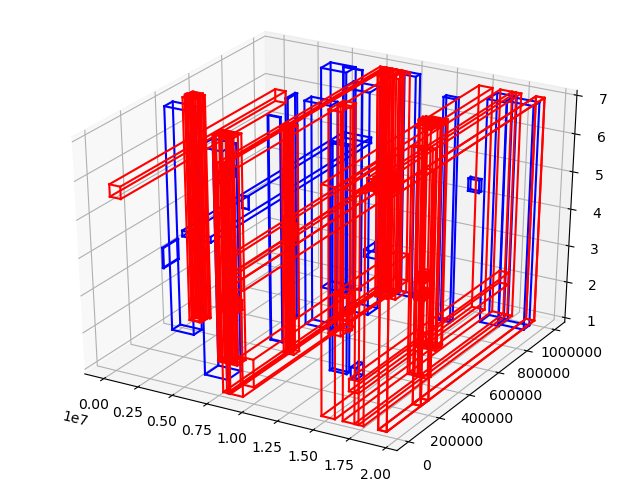

In [195]:
show_queries_3d(mixed_queris[1], mixed_queris[0])

<IPython.core.display.Javascript object>


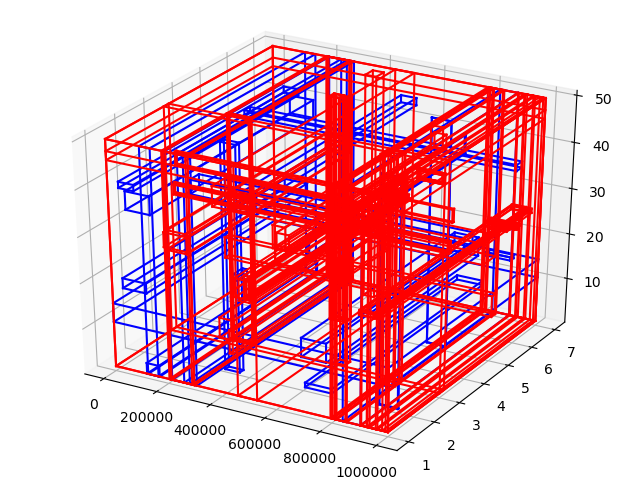

In [184]:
show_queries_3d(mixed_queris[1], mixed_queris[0], 1, 2, 3)

In [71]:
# - - - Test Case 5 - - -
# Target: 4 dimensional distribution query classification
queryset = training_set
buckets = [300, 300, 300, 300]
is_query_hist = True 
hist_type = 1
query_hist = MyHist(queryset, buckets, domains, is_query_hist, hist_type, dimension_probability)
disqids = query_hist.filter_distribution_query()
disqids.sort()
print(disqids) # should contains the distribution queries in training set
print(len(disqids))
print(np.count_nonzero(np.array(disqids)[:] < 100))

[6, 7, 8, 15, 17, 19, 25, 31, 32, 34, 35, 37, 38, 40, 47, 63, 64, 65, 66, 67, 70, 75, 77, 79, 83, 85, 88, 89, 90, 92, 94, 96, 97, 100, 101, 104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 117, 118, 119, 121, 122, 124, 125, 126, 127, 128, 129, 130, 132, 134, 135, 136, 137, 138, 140, 142, 143, 145, 146, 150, 151, 153, 154, 155, 156, 157, 158, 159, 161, 162, 164, 165, 166, 169, 170, 171, 172, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 185, 186, 187, 188, 190, 192, 193, 194, 195, 196, 197, 198, 199, 201, 203, 204, 205, 206, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 224, 227, 228, 229, 230, 231, 232, 234, 235, 236, 237, 238, 239, 240, 241, 242, 244, 245, 247, 248, 249, 250, 252, 253, 254, 255, 256, 257, 258, 260, 261, 262, 263, 264, 266, 268, 269, 270, 271, 272, 274, 275, 276, 277, 278, 280, 281, 282, 283, 284, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 

In [234]:
# - - - Test Case 2 - - -
# Target: 4 dimensional NORA using hist_type 1
# Result:
# ... generate dataset and queryset here

queryset = training_set
data_threshold = block_size
dim_probs = dimension_probability
use_data_hist = False
data_hist_buckets = [300, 300, 300, 300]
data_hist_type = 0
use_query_hist = True
query_hist_buckets = [300, 300, 300, 300]
query_hist_type = 1
query_threshold_up = 2
query_threshold_low = 2

Nora = NORA(dataset, queryset, domains, data_threshold, dim_probs, use_data_hist, data_hist_buckets, data_hist_type,
           use_query_hist, query_hist_buckets, query_hist_type, query_threshold_up, query_threshold_low)
nora_kdnodes = Nora.initialization()

<IPython.core.display.Javascript object>


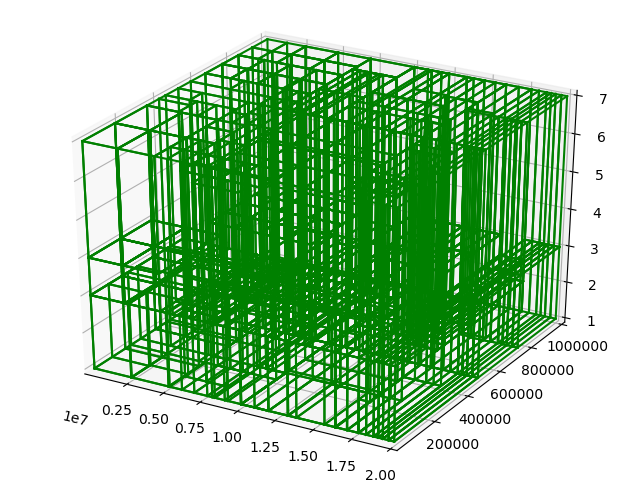

In [237]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# this is the 3D version
def visualize_kdnodes_and_query_3(kdnodes, query_distribution, query_random, domains, dim1 = 0, dim2 = 1, dim3 = 2, path=None):
    
    fig = plt.figure()
    ax = Axes3D(fig)
    
    plt.xlim(domains[dim1][0],domains[dim1][1])
    plt.ylim(domains[dim2][0],domains[dim2][1])
    ax.set_zlim(domains[dim3][0],domains[dim3][1])
    
    for i in range(len(kdnodes)):
        
        L1 = kdnodes[i][0][dim1][0]
        L2 = kdnodes[i][0][dim2][0]
        L3 = kdnodes[i][0][dim3][0]
        U1 = kdnodes[i][0][dim1][1]
        U2 = kdnodes[i][0][dim2][1]
        U3 = kdnodes[i][0][dim3][1]
    
        # the 12 lines to form a rectangle
        x = [L1, U1]
        y = [L2, L2]
        z = [L3, L3]
        ax.plot3D(x,y,z,color="g")
        y = [U2, U2]
        ax.plot3D(x,y,z,color="g")
        z = [U3, U3]
        ax.plot3D(x,y,z,color="g")
        y = [L2, L2]
        ax.plot3D(x,y,z,color="g")
        
        x = [L1, L1]
        y = [L2, U2]
        z = [L3, L3]
        ax.plot3D(x,y,z,color="g")
        x = [U1, U1]
        ax.plot3D(x,y,z,color="g")
        z = [U3, U3]
        ax.plot3D(x,y,z,color="g")
        x = [L1, L1]
        ax.plot3D(x,y,z,color="g")
        
        x = [L1, L1]
        y = [L2, L2]
        z = [L3, U3]
        ax.plot3D(x,y,z,color="g")
        x = [U1, U1]
        ax.plot3D(x,y,z,color="g")
        y = [U2, U2]
        ax.plot3D(x,y,z,color="g")
        x = [L1, L1]
        ax.plot3D(x,y,z,color="g")
    
    for i in range(len(query_random)):
        
        L1 = query_random[i][dim1][0]
        L2 = query_random[i][dim2][0]
        L3 = query_random[i][dim3][0]
        U1 = query_random[i][dim1][1]
        U2 = query_random[i][dim2][1]
        U3 = query_random[i][dim3][1]
        
        # the 12 lines to form a rectangle
        x = [L1, U1]
        y = [L2, L2]
        z = [L3, L3]
        ax.plot3D(x,y,z,color="b")
        y = [U2, U2]
        ax.plot3D(x,y,z,color="b")
        z = [U3, U3]
        ax.plot3D(x,y,z,color="b")
        y = [L2, L2]
        ax.plot3D(x,y,z,color="b")
        
        x = [L1, L1]
        y = [L2, U2]
        z = [L3, L3]
        ax.plot3D(x,y,z,color="b")
        x = [U1, U1]
        ax.plot3D(x,y,z,color="b")
        z = [U3, U3]
        ax.plot3D(x,y,z,color="b")
        x = [L1, L1]
        ax.plot3D(x,y,z,color="b")
        
        x = [L1, L1]
        y = [L2, L2]
        z = [L3, U3]
        ax.plot3D(x,y,z,color="b")
        x = [U1, U1]
        ax.plot3D(x,y,z,color="b")
        y = [U2, U2]
        ax.plot3D(x,y,z,color="b")
        x = [L1, L1]
        ax.plot3D(x,y,z,color="b")
        
        
    for i in range(len(query_distribution)):
        L1 = query_distribution[i][dim1][0]
        L2 = query_distribution[i][dim2][0]
        L3 = query_distribution[i][dim3][0]
        U1 = query_distribution[i][dim1][1]
        U2 = query_distribution[i][dim2][1]
        U3 = query_distribution[i][dim3][1]
        
        # the 12 lines to form a rectangle
        x = [L1, U1]
        y = [L2, L2]
        z = [L3, L3]
        ax.plot3D(x,y,z,color="r")
        y = [U2, U2]
        ax.plot3D(x,y,z,color="r")
        z = [U3, U3]
        ax.plot3D(x,y,z,color="r")
        y = [L2, L2]
        ax.plot3D(x,y,z,color="r")
        
        x = [L1, L1]
        y = [L2, U2]
        z = [L3, L3]
        ax.plot3D(x,y,z,color="r")
        x = [U1, U1]
        ax.plot3D(x,y,z,color="r")
        z = [U3, U3]
        ax.plot3D(x,y,z,color="r")
        x = [L1, L1]
        ax.plot3D(x,y,z,color="r")
        
        x = [L1, L1]
        y = [L2, L2]
        z = [L3, U3]
        ax.plot3D(x,y,z,color="r")
        x = [U1, U1]
        ax.plot3D(x,y,z,color="r")
        y = [U2, U2]
        ax.plot3D(x,y,z,color="r")
        x = [L1, L1]
        ax.plot3D(x,y,z,color="r")
    
    if path != None:
        fig.savefig(path)
    
    plt.show()
    
visualize_kdnodes_and_query_3(nora_kdnodes, [], [], domains)

<IPython.core.display.Javascript object>


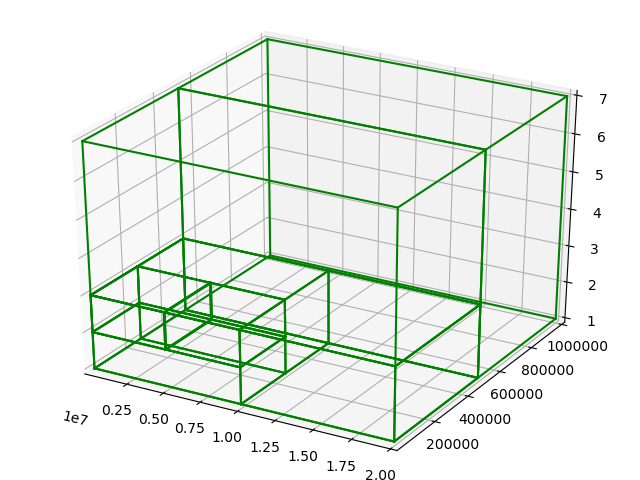

In [197]:
visualize_kdnodes_and_query_3(Nora.akd_kdnodes, [], [], domains)

In [143]:
from Query import *

importing Jupyter notebook from Query.ipynb


In [238]:
Query(testing_set, nora_kdnodes, random_percentage)

Query 0  Cost:  188076  Intersected Partitions: [230, 267, 268, 271, 272, 291, 292, 295, 296, 302, 347, 348, 376]
Query 1  Cost:  124345  Intersected Partitions: [191, 192, 195, 196, 199, 200, 203, 204]
Query 2  Cost:  28408  Intersected Partitions: [86, 88]
Query 3  Cost:  88069  Intersected Partitions: [29, 30, 52, 153, 164]
Query 4  Cost:  74096  Intersected Partitions: [201, 205, 288, 305, 344]
Query 5  Cost:  56985  Intersected Partitions: [264, 288, 332, 334]
Query 6  Cost:  136775  Intersected Partitions: [216, 218, 220, 222, 312, 313, 338, 339, 342, 343]
Query 7  Cost:  386434  Intersected Partitions: [98, 99, 137, 141, 152, 153, 161, 162, 163, 164, 171, 172, 173, 174, 177, 253, 254, 261, 262, 276, 297, 306, 307, 308, 309, 331, 335, 344, 370]
Query 8  Cost:  11022  Intersected Partitions: [319]
Query 9  Cost:  182904  Intersected Partitions: [223, 225, 273, 276, 277, 298, 309, 353, 354, 366, 371, 374, 377]
Query 10  Cost:  279707  Intersected Partitions: [8, 21, 36, 70, 71, 102

In [158]:
len(Nora.akd_kdnodes)

21

In [159]:
len(Nora.lkd_kdnodes)

129

In [160]:
len(Nora.kdt_kdnodes)

382

In [239]:
# Comparision Group
competitor_qdt_kdnodes = Nora.run_competitor_QDT()
competitor_kdt_kdnodes = Nora.run_competitor_KDT()

In [241]:
print(len(competitor_qdt_kdnodes))
print(len(competitor_kdt_kdnodes))

91
224


<IPython.core.display.Javascript object>


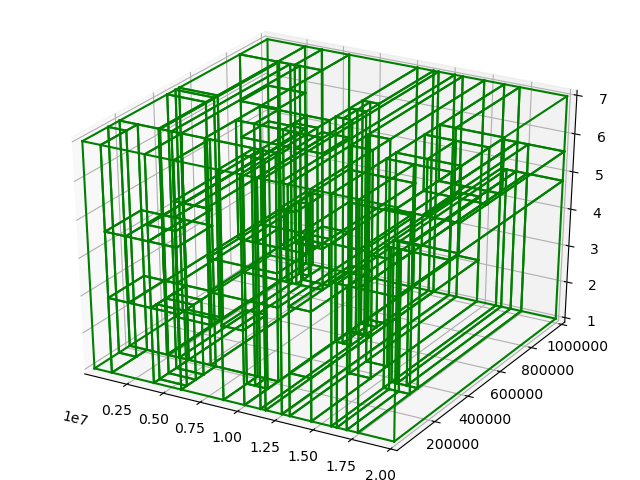

<IPython.core.display.Javascript object>


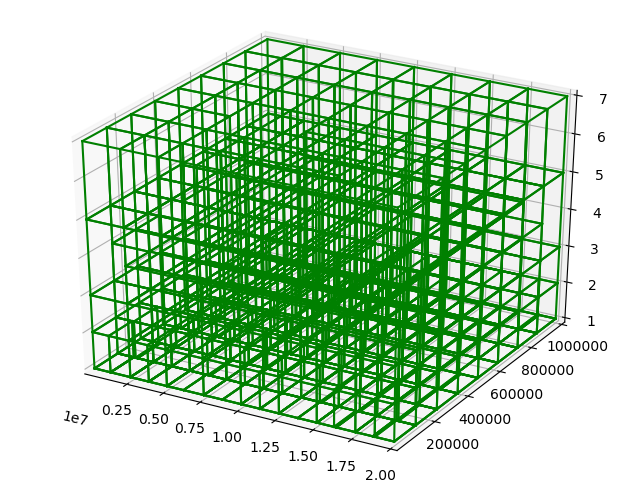

In [175]:
visualize_kdnodes_and_query_3(competitor_qdt_kdnodes, [], [], domains)
visualize_kdnodes_and_query_3(competitor_kdt_kdnodes, [], [], domains)

In [240]:
Query(testing_set, competitor_qdt_kdnodes, random_percentage)
print("\n = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = \n")
Query(testing_set, competitor_kdt_kdnodes, random_percentage)

Query 0  Cost:  525634  Intersected Partitions: [15, 19, 31, 45, 60, 89]
Query 1  Cost:  432553  Intersected Partitions: [25]
Query 2  Cost:  472045  Intersected Partitions: [0]
Query 3  Cost:  265863  Intersected Partitions: [20, 69, 80]
Query 4  Cost:  487778  Intersected Partitions: [14, 22, 25, 30, 54]
Query 5  Cost:  259447  Intersected Partitions: [6, 14, 30, 73]
Query 6  Cost:  718490  Intersected Partitions: [21, 25, 53]
Query 7  Cost:  972228  Intersected Partitions: [8, 10, 42, 52, 54, 61, 67, 73, 76, 80, 83, 86]
Query 8  Cost:  143227  Intersected Partitions: [27, 84]
Query 9  Cost:  992892  Intersected Partitions: [18, 33, 41, 42, 50, 55, 58, 59, 65, 68, 72, 82, 83, 85, 87]
Query 10  Cost:  479430  Intersected Partitions: [3, 19, 27, 34, 60, 63, 66, 74, 77, 84, 88, 89, 90]
Query 11  Cost:  122447  Intersected Partitions: [10, 14, 37, 41, 54, 58, 76]
Query 12  Cost:  13579  Intersected Partitions: [14]
Query 13  Cost:  560704  Intersected Partitions: [14, 18, 22, 26, 30, 37,